In [1]:
%matplotlib inline

In [10]:
import numpy as np
import pandas as pd
import random
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Data Loading 

In [11]:
X = np.loadtxt("../data/X.txt")
y = np.loadtxt("../data/y.txt")
LABELS = np.loadtxt("../data/labels.txt")

In [ ]:
blocks = int(len(X) / 70)
X_ = np.array(np.split(X, blocks))      # X_.shape == (18355, 70, 84) 18355 valid videos, 70 time frames, 84 features

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=42)

In [13]:
n_steps = 70                           # 70 timesteps per series
n_categories = len(LABELS)

In [36]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [29]:
y_train = y_train.reshape([len(y_train), 1])
y_test = y_test.reshape([len(y_test), 1])

### Pre-Process 

In [37]:
tensor_X_test = torch.from_numpy(X_test)
print('test_data_size:',tensor_X_test.size())
tensor_y_test = torch.from_numpy(y_test)
print('test_label_size:',tensor_y_test.size())
n_data_size_test = tensor_X_test.size()[0]
print('n_data_size_test:',n_data_size_test)

tensor_X_train = torch.from_numpy(X_train)
print('train_data_size:',tensor_X_train.size())
tensor_y_train = torch.from_numpy(y_train)
print('train_label_size:',tensor_y_train.size())
n_data_size_train = tensor_X_train.size()[0]
print('n_data_size_train:',n_data_size_train)

test_data_size: torch.Size([3671, 70, 84])
test_label_size: torch.Size([3671, 1])
n_data_size_test: 3671
train_data_size: torch.Size([14684, 70, 84])
train_label_size: torch.Size([14684, 1])
n_data_size_train: 14684


### Model

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [22]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(70)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [23]:
n_hidden = 128
n_joints = 42 * 2
n_categories = 2000
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(84, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=2000, bias=True)
  (bn): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [24]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

### Getting Random Data 

In [25]:
import random
def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = tensor_X_train
        y = tensor_y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = tensor_X_test
        y = tensor_y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

n_iters = 100000
print_every = 10
plot_every = 1000
batch_size = 128

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    
    output = rnn(input_sequence)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
    
    # if only one element in tensor, .item() returns this number as a regular python number
    current_loss += loss.item()
    
    category = LABELS[int(category_tensor[0])]

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

In [15]:
torch.save(rnn.state_dict(),'lstm_6_bn.pkl')

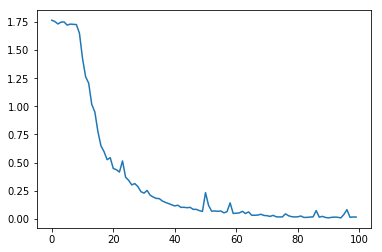

In [16]:
plt.figure()
plt.plot(all_losses)

### Testing

In [17]:
def test(flag):
    if flag == 'train':
        n = n_data_size_train
    elif flag == 'test':
        n = n_data_size_test   
        
    with torch.no_grad():
        right = 0
        for i in range(n):
            category_tensor, inputs = randomTrainingExampleBatch(1,flag,i)
            category = LABELS[int(category_tensor[0])]
            inputs = inputs.to(device)
            output = rnn(inputs)
            guess, guess_i = categoryFromOutput(output)
            category_i = LABELS.index(category)
            if category_i == guess_i:
                right+=1
    print(flag,'accuracy',right/n)

In [18]:
test('test')

test accuracy 0.967831681446705


In [19]:
test('train')

train accuracy 0.9888618784530386


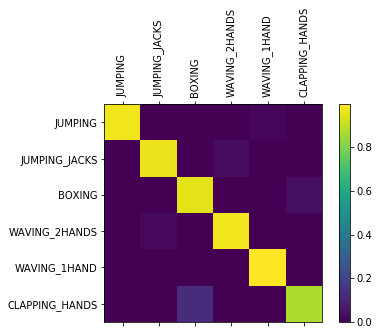

In [20]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_data_size_test

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, inputs = randomTrainingExampleBatch(1,'test',i)
    category = LABELS[int(category_tensor[0])]
    inputs = inputs.to(device)
    output = rnn(inputs)
    guess, guess_i = categoryFromOutput(output)
    category_i = LABELS.index(category)
    confusion[category_i][guess_i] += 1
     
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + LABELS, rotation=90)
ax.set_yticklabels([''] + LABELS)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()